In [ ]:
####
# Creator: Rowan Converse (rowanconverse@unm.edu)
# Date: 2023/03/03
# Purpose: Refine redundant image labels through 1- clustering; 2- species ID via plurality vote; 3- median box
####

In [1]:
#Import modules
import json
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import patches, text, patheffects
import cv2
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

In [2]:
#DEFINE VISUALIZATION PARAMETERS FOR DBSCAN OUTPUTS
def plot_dbscan(db, X):
    # make a mask for each core point
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True

    plt.figure(figsize=[10, 10])
    unique_labels = set(db.labels_)
    for k in unique_labels:
        kdx = db.labels_ == k
        if k == -1:
            # these are the noise points
            color = 'k'
            plt.scatter(X[kdx, 0], X[kdx, 1], color=color, s=3)
        else:
            color = f'C{k}'
            core_kdx = kdx & core_samples_mask
            non_core_kdx = kdx & ~core_samples_mask
            plt.scatter(X[core_kdx, 0], X[core_kdx, 1], color=color, s=35, edgecolors=color)
            plt.scatter(X[non_core_kdx, 0], X[non_core_kdx, 1], color=color, s=5)

    plt.xlim(0, 20)
    plt.ylim(0, 20)
    plt.xlabel('X')
    plt.ylabel('Y')

In [3]:
#JSON file with all image labels
labelpath = r"/Users/rowanconverse/Library/CloudStorage/OneDrive-UniversityofNewMexico/CV4Ecology/Prototyping/Data/Labels/coco/20220227_dgc.json"
with open(labelpath) as f:
  cocozoo = pd.read_json(f)

#Directory of images-- remember to change this to the full directory when the script is ready
imgpath = r"/Users/rowanconverse/Library/CloudStorage/OneDrive-UniversityofNewMexico/CV4Ecology/Prototyping/Data/Imagery/SB597/scratch/test"
imglist = os.listdir(imgpath)

In [24]:
#Creating a multi-image subset to work with
testimg = "20220111_LaJoya_2_0196_06_03.png"
df = cocozoo[cocozoo["filename"] == testimg]
#df["filename"].unique()
#df.groupby("filename")


In [25]:
df.head()

,annotation_id,bbox,area,category_id,category,image_id,filename,labeler_id
923988,923989,"[271.7648620605469, -10.186065673828125, 60.82...",3365.030525,3,Duck,24147,20220111_LaJoya_2_0196_06_03.png,4088
923989,923990,"[313.66802978515625, 106.30322265625, 42.80432...",3022.552272,3,Duck,24147,20220111_LaJoya_2_0196_06_03.png,4088
923990,923991,"[261.8522644042969, 136.43753051757812, 38.298...",2566.584549,3,Duck,24147,20220111_LaJoya_2_0196_06_03.png,4088
923991,923992,"[454.69708251953125, 230.88833618164062, 40.10...",2074.143672,3,Duck,24147,20220111_LaJoya_2_0196_06_03.png,4088
923992,923993,"[528.5908813476562, 248.87896728515625, 46.859...",2613.397968,3,Duck,24147,20220111_LaJoya_2_0196_06_03.png,4088


In [42]:
#CREATE NEW COLUMNS FOR INPUT INTO DBSCAN

#Derive bounding box centers
bboxes = df["bbox"]
c_x = []
c_y = []
x = []
y = []
w = []
h = []
centers = []
for coord in bboxes:
    center = (coord[0]+(coord[2]/2), coord[1]+(coord[3]/2))
    c_x.append(center[0])
    c_y.append(center[1])
    x.append(coord[0])
    y.append(coord[1])
    w.append(coord[2])
    h.append(coord[3])
    centers.append(center)
#Make these centers into a coordinate format
coords = []
for row in centers:
    coord = list(row)
    coords.append(coord)
#Append new columns to dataframe for manipulating later
df["c_x"] = c_x
df["c_y"] = c_y
df['x'] = x
df['y'] = y
df['w'] = w
df['h'] = h

df.head()


/var/folders/21/q9_tvtjj53n6mfprd_174cz00000gn/T/ipykernel_98499/756392880.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["c_x"] = c_x
/var/folders/21/q9_tvtjj53n6mfprd_174cz00000gn/T/ipykernel_98499/756392880.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["c_y"] = c_y
/var/folders/21/q9_tvtjj53n6mfprd_174cz00000gn/T/ipykernel_98499/756392880.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

,annotation_id,bbox,area,category_id,category,image_id,filename,labeler_id,centers,x,y,w,h,cluster_id,c_x,c_y
923988,923989,"[271.7648620605469, -10.186065673828125, 60.82...",3365.030525,3,Duck,24147,20220111_LaJoya_2_0196_06_03.png,4088,"[302.17845153808594, 17.474517822265625]",271.764862,-10.186066,60.827179,55.321167,0,302.178452,17.474518
923989,923990,"[313.66802978515625, 106.30322265625, 42.80432...",3022.552272,3,Duck,24147,20220111_LaJoya_2_0196_06_03.png,4088,"[335.0701904296875, 141.60984802246094]",313.668030,106.303223,42.804321,70.613251,1,335.070190,141.609848
923990,923991,"[261.8522644042969, 136.43753051757812, 38.298...",2566.584549,3,Duck,24147,20220111_LaJoya_2_0196_06_03.png,4088,"[281.00157165527344, 169.945068359375]",261.852264,136.437531,38.298615,67.015076,2,281.001572,169.945068
923991,923992,"[454.69708251953125, 230.88833618164062, 40.10...",2074.143672,3,Duck,24147,20220111_LaJoya_2_0196_06_03.png,4088,"[474.74755859375, 256.74986267089844]",454.697083,230.888336,40.100952,51.723053,5,474.747559,256.749863
923992,923993,"[528.5908813476562, 248.87896728515625, 46.859...",2613.397968,3,Duck,24147,20220111_LaJoya_2_0196_06_03.png,4088,"[552.0206298828125, 276.7644348144531]",528.590881,248.878967,46.859497,55.770935,3,552.020630,276.764435


In [44]:
#coords
array1 = df[["c_x", "c_y"]].to_numpy()

In [38]:
#Transform into numpy array for input into DBSCAN
array = np.array(coords)
array


array([[302.17845154,  17.47451782],
       [335.07019043, 141.60984802],
       [281.00157166, 169.94506836],
       [474.74755859, 256.74986267],
       [552.02062988, 276.76443481],
       [533.09661865, 403.82330322],
       [536.75      , 396.9666748 ],
       [549.25      , 269.46666718],
       [478.75      , 240.96666718],
       [328.75      , 138.46665955],
       [284.75      , 166.96665955],
       [302.75      ,   3.96665955],
       [284.5       , 166.25      ],
       [332.5       , 136.75      ],
       [300.        ,  10.75      ],
       [478.        , 241.25      ],
       [552.        , 272.75      ],
       [535.5       , 400.75      ],
       [543.2671814 , 394.99827576],
       [570.28713989, 275.09712219],
       [479.09472656, 237.26916504],
       [271.37866211, 162.9642334 ],
       [330.14709473, 141.01050186],
       [287.59063721,  19.75835896],
       [555.92617798, 262.92575073],
       [470.05911255, 243.02539062],
       [333.7538147 , 128.57673645],
 

In [27]:
#Define comparison number to flag for bad clustering
comp = int(len(df)) / len(((df["labeler_id"].unique())))
comp

6.0

In [45]:
#RUN DBSCAN

#define parameters for clustering; eps is the k-nn distance value from above 
db = DBSCAN(eps=15, min_samples=5).fit(array1)
#stores the cluster labels
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
decision = comp / int(n_clusters_)
if decision > 0.9:
    print("Number of clusters is good")
else:
    print("Number of clusters differs from expected by >10%, please verify")
print("Estimated number of noise points: %d" % n_noise_)

#Add cluster ID to dataframe
df["cluster_id"] = labels

Estimated number of clusters: 6
Number of clusters is good
Estimated number of noise points: 0


/var/folders/21/q9_tvtjj53n6mfprd_174cz00000gn/T/ipykernel_98499/3836083838.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["cluster_id"] = labels


In [70]:
#CREATE REFINED DATASET:

#Define this at an earlier step-- dictionary of category values
categories = {1: "Crane", 2: 'Goose', 3:'Duck'}

#Derive median bounding box
refined = df.groupby("cluster_id")['x','y','w','h'].agg(pd.Series.median)
refined.reset_index("cluster_id")
#Make median bounding box into its own column in list form
refined['bbox']= refined.values.tolist()
#Derive plurality vote of class ID
mode_class = df.groupby("cluster_id")["filename",'category_id'].agg(pd.Series.mode)
m = mode_class.reset_index("cluster_id")
#Join the refined results together
refined_id = pd.merge(refined, mode_class, left_on="cluster_id", right_on="cluster_id")
#Add back a column with category name to the refined results (optional)
refined_id['category'] = refined_id["category_id"].map(categories)
refined_id = refined_id.drop(columns=['x','y','w','h'])
refined_id

/var/folders/21/q9_tvtjj53n6mfprd_174cz00000gn/T/ipykernel_93735/1811144758.py:7: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  refined = df.groupby("cluster_id")['x','y','w','h'].agg(pd.Series.median)
/var/folders/21/q9_tvtjj53n6mfprd_174cz00000gn/T/ipykernel_93735/1811144758.py:12: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  mode_class = df.groupby("cluster_id")["filename",'category_id'].agg(pd.Series.mode)


,bbox,filename,category_id,category
cluster_id,,,,
0,"[269.03868103027344, -12.845115661621094, 64.6...",20220111_LaJoya_2_0196_06_03.png,3,Duck
1,"[305.625, 106.03912353515625, 55.0004272460937...",20220111_LaJoya_2_0196_06_03.png,3,Duck
2,"[259.6112365722656, 135.64845275878906, 51.000...",20220111_LaJoya_2_0196_06_03.png,3,Duck
3,"[523.53125, 246.0749969482422, 62.799987792968...",20220111_LaJoya_2_0196_06_03.png,3,Duck
4,"[506.65625, 366.75, 59.046478271484375, 69.077...",20220111_LaJoya_2_0196_06_03.png,3,Duck
5,"[451.51251220703125, 203.384765625, 50.5, 77.9...",20220111_LaJoya_2_0196_06_03.png,3,Duck


In [ ]:
#STEPS FOR EXPORT OF REFINED RESULTS FOR USE AS TRAIN/VAL/TEST (not split yet; determine split after getting new data stats)

#add individual annotation ID column
export = refined_id.reset_index
#drop "cluster ID" column
export.drop(columns="cluster_id")
#save to csv
export.to_csv("20230303_consensuslabels.csv")

In [73]:
#Join refined results back to original dataframe for analysis, and save:
df_analysis = pd.merge(df, refined_id, left_on="cluster_id", right_on="cluster_id")
df_analysis = df_analysis.drop(columns=['centers','area','x','y','w','h', 'filename_y'])
df_analysis = df_analysis.rename(columns={'filename_x':'filename', 'bbox_x': 'bbox_orig', 'category_id_x': 'cat_id_orig', "category_x": "cat_orig", 'bbox_y': 'bbox_refined', 'category_id_y': 'cat_id_refined', "category_y": "cat_refined"})
df_analysis.head()

,annotation_id,bbox_orig,cat_id_orig,cat_orig,image_id,filename,labeler_id,cluster_id,bbox_refined,cat_id_refined,cat_refined
0,923989,"[271.7648620605469, -10.186065673828125, 60.82...",3,Duck,24147,20220111_LaJoya_2_0196_06_03.png,4088,0,"[269.03868103027344, -12.845115661621094, 64.6...",3,Duck
1,934866,"[278.25, -22.533340454101562, 49, 53]",3,Duck,24147,20220111_LaJoya_2_0196_06_03.png,4585,0,"[269.03868103027344, -12.845115661621094, 64.6...",3,Duck
2,947941,"[274, -10.75, 52, 43]",3,Duck,24147,20220111_LaJoya_2_0196_06_03.png,4756,0,"[269.03868103027344, -12.845115661621094, 64.6...",3,Duck
3,954344,"[252.12692260742188, -21.447099685668945, 70.9...",3,Duck,24147,20220111_LaJoya_2_0196_06_03.png,4721,0,"[269.03868103027344, -12.845115661621094, 64.6...",3,Duck
4,1033382,"[264.29693603515625, -14.940231323242188, 68.3...",3,Duck,24147,20220111_LaJoya_2_0196_06_03.png,3441,0,"[269.03868103027344, -12.845115661621094, 64.6...",3,Duck


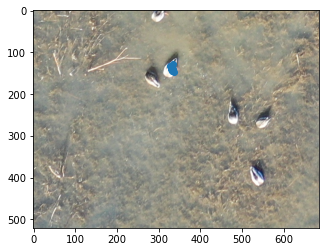

In [38]:
#THIS WAS JUST CHECKING THAT THE CLUSTERS GROUPED AS EXPECTED WITH A QUICK VISUALIZATION
subset = df.loc[df['cluster_id'] == 1]

x_df = []
y_df = []
for coord in subset["centers"]:
    x1 = coord[0]
    x_df.append(x1)
    y1 = coord[1]
    y_df.append(y1)

fig, ax = plt.subplots()
img = cv2.imread(imgpath+"/20220111_LaJoya_2_0196_06_03.png")
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
ax.imshow(img)
ax.scatter(x_df,y_df)


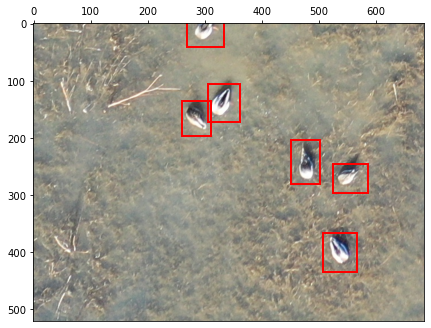

In [39]:
#Checking that refined bounding boxes appear as expected
bboxes = refined["bbox"]

def get_bb(bboxes, img):  
    boxes = bboxes.copy()
    
    return np.squeeze(boxes)

def img_show(img, ax = None, figsize=(7,11)):
  if ax is None: fig, ax = plt.subplots(figsize=figsize)
  ax.xaxis.tick_top()
  ax.imshow(img)  
  return ax

def draw_box(img, ax, bb):
  patch = ax.add_patch(patches.Rectangle((bb[0],bb[1]), bb[2], bb[3], fill=False, edgecolor='red', lw=2))
  
def plot_sample(img,bboxes, ax=None, figsize=(7,11)):
  bb = get_bb(bboxes, img)
  ax = img_show(img, ax=ax)
  for i in range(len(bboxes)):
    draw_box(img,ax,bb[i])

plot_sample(img,bboxes)